In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

(1280, 720)


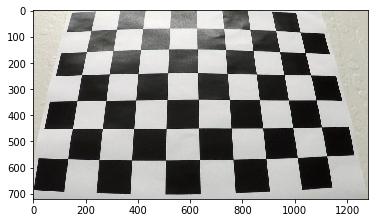

In [43]:
img = mpimg.imread("./camera_cal/calibration3.jpg")
# print(img.shape)
plt.imshow(img)

In [56]:
import glob

def calibrateCamera():
    imgpoints = []
    objpoints = []

    objp = np.zeros((9*6, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    images = glob.glob("./camera_cal/calibration*.jpg")

    for fname in images:
        img = mpimg.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret,corners = cv2.findChessboardCorners(gray, (9, 6), None)
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)

            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
            plt.show()

    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None)
    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

def undistortImage(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

ret, mtx, dist, rvecs, tvecs = calibrateCamera()

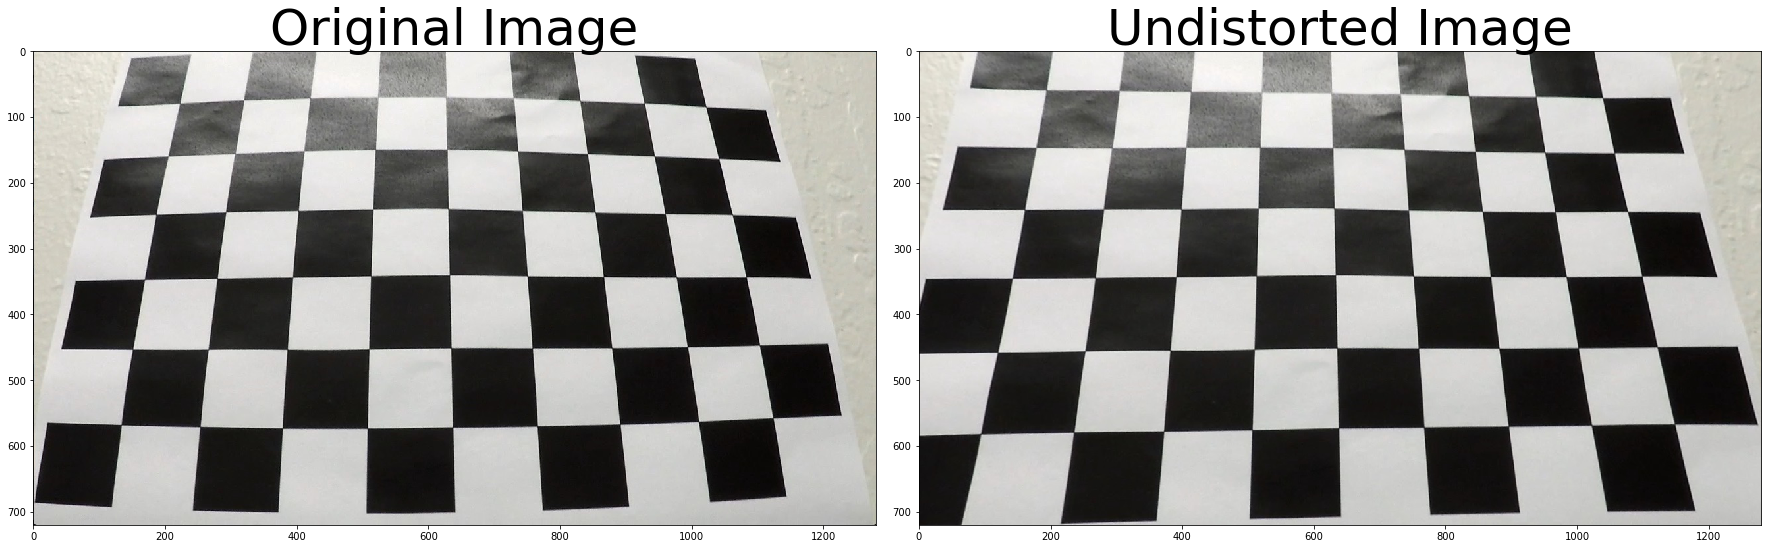

In [57]:
img = mpimg.imread("./camera_cal/calibration3.jpg")
undistorted = undistortImage(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/undistorted_image.jpg')

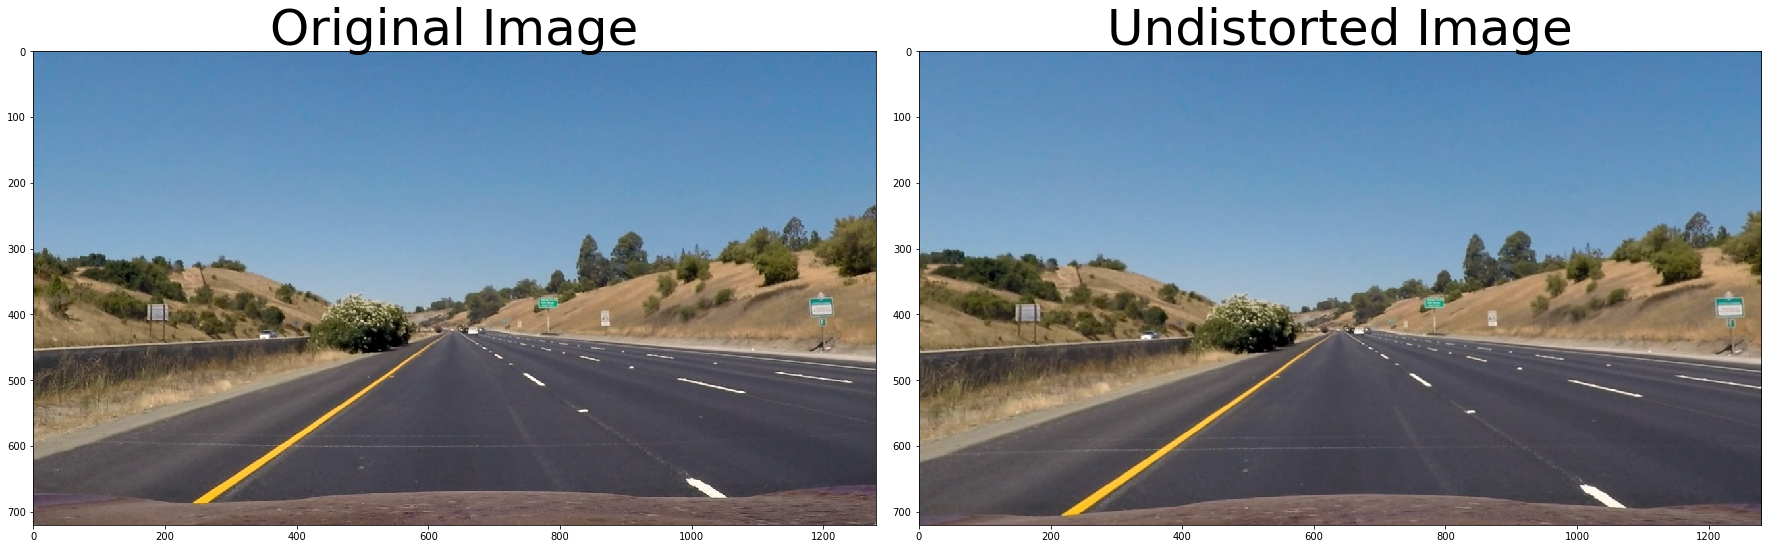

In [94]:
# img = mpimg.imread("./test_images/test2.jpg")
img = mpimg.imread("./test_images/straight_lines1.jpg")
undistorted = undistortImage(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

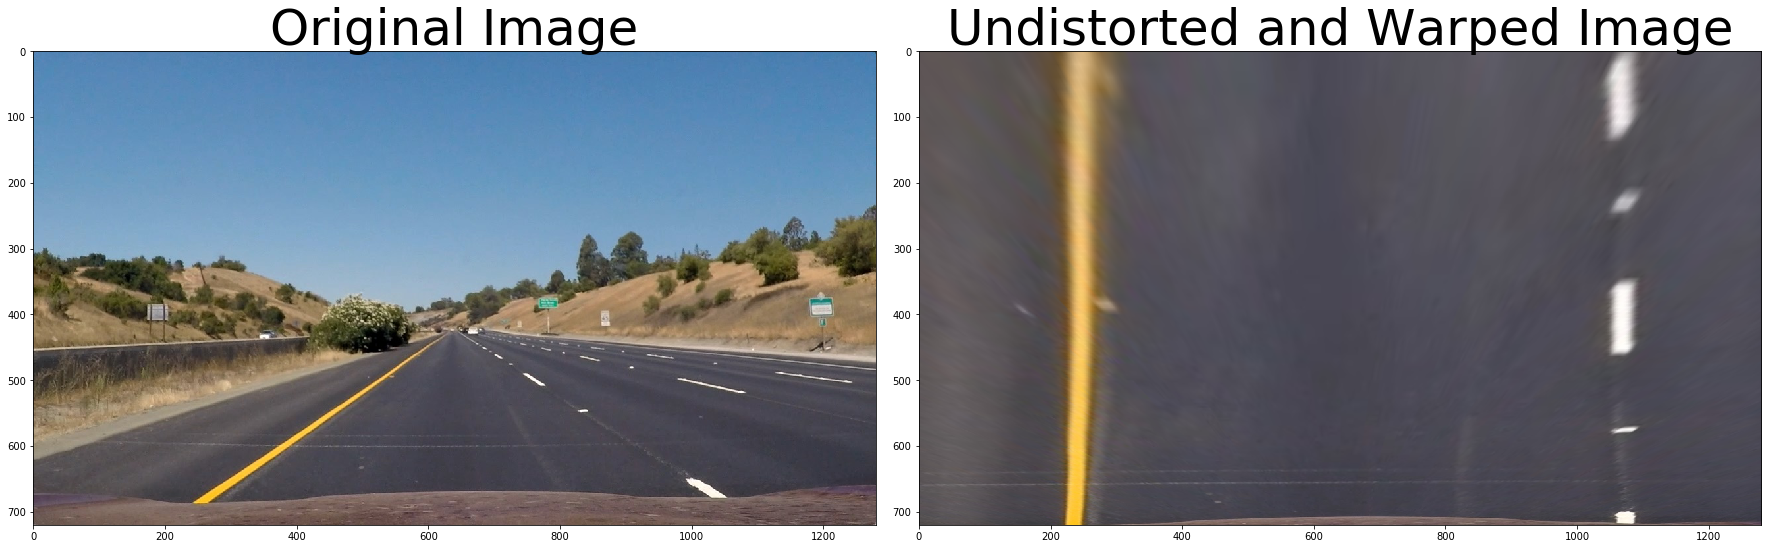

In [112]:
def getWarpedImage(img):
    h, w = img.shape[:2]
    src = np.float32([
        [w, h-20],
        [0, h-20],
        [546, 460],
        [732, 460]
    ])

    dst = np.float32([
        [w, h],
        [0, h],
        [0, 0],
        [w, 0]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)

    return warped

top_down = getWarpedImage(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


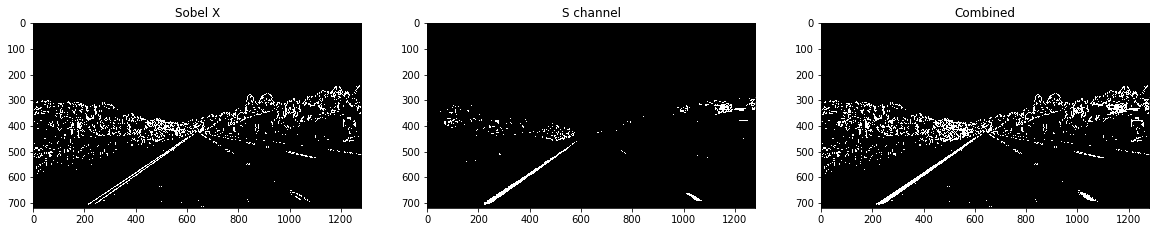

In [108]:
def sobelX(img, sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobelx)

    scaled = np.uint8(abs_sobel*255/np.max(abs_sobel))

    mask = np.zeros_like(scaled)
    mask[(scaled>=thresh[0]) & (scaled<=thresh[1])] = 1
    
    return mask

def sobelDir(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradient = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    mask = np.zeros_like(gray)
    mask[(gradient>=thresh[0]) & (gradient<=thresh[1])] = 1
    
    return mask

def hlsMask(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:, 2]
    
    mask = np.zeros_like(S)
    mask[(S>thresh[0]) & (S<=thresh[1])] = 1
    
    return mask

def pipeline(img):
    sobelx = sobelX(img, 5, thresh=(20, 100))
    grad = sobelDir(img, 15, thresh=(0.7, 1.3))
    hlsbinary = hlsMask(undistorted, (120, 255))

    combined = np.zeros_like(sobelx)
    combined[(sobelx==1) | (hlsbinary==1)]=1
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.set_title('Sobel X')
    ax1.imshow(sobelx, cmap='gray')

    ax2.set_title('S channel')
    ax2.imshow(hlsbinary, cmap='gray')
    
    ax3.set_title('Combined')
    ax3.imshow(combined, cmap='gray')
    
pipeline(undistorted)